https://www.kaggle.com/code/jinsolkwon/rul-predictions-using-pytorch-lstm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA

pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)


I loaded all the files in Colab notebook

In [ ]:
df_train=pd.read_csv('train_FD001.txt',header=None,sep=' ')
df_test=pd.read_csv('test_FD001.txt', header=None, sep=' ')
rul_test=pd.read_csv('RUL_FD001.txt', header=None)

In [ ]:
for df in [df_train,df_test,rul_test]:
  display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


,0
0,112
1,98
2,69
3,82
4,91


In [ ]:
df_train.shape,df_test.shape,rul_test.shape

((20631, 28), (13096, 28), (100, 1))

In [ ]:
col_names=[]
col_names.append('unit')
col_names.append('time')

for i in range (1,4):
  col_names.append('os'+str(i))
for i in range (1,22):
  col_names.append('s'+str(i))

df_train=df_train.iloc[:,:-2].copy()    #coge todas las filas menos las 2 ultimas columnas
df_train.columns=col_names
display(df_train.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
df_test=df_test.iloc[:,:-2].copy()
df_test.columns=col_names
display(df_test.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


📌 Attaching RUL(remaining useful lifetime) values to the datasets.

For the train data, the RUL values are not specified, but the document regarding this dataset specifies that for the training data, all the engines were run to failure. Thus, for example, if we had five rows for a specific unit, say unit 7:

unit	time cycle
7	1
7	2
7	3
7	4
7	5

Then we know that the last row is when the RUL value becomes 0 (failure), so the RUL for this unit would be attached in this way:

unit	time cycle	RUL
7	1	4
7	2	3
7	3	2
7	4	1
7	5	0

For the test data, we have the 'solutions' for the test engines in a separate file called rul_test (the name that I used for dataframe). I will use that to attach the RUL values for the test as well.

In [ ]:
from sqlalchemy.engine.cursor import ResultFetchStrategy
rul_list=[]

for n in np.arange(1,101):   #there are 100 trajectories in FD001
  time_list=np.array(df_train[df_train['unit']==n]['time'])
  length=len(time_list)
  rul=list(length-time_list)
  rul_list+=rul

df_train['rul']=rul_list

rul_list=[]

for n in np.arange(1,101):
  time_list=np.array(df_test[df_train['unit']==n]['time'])
  length=len(time_list)
  rul=list(length-time_list)
  rul_list+=rul

df_test['rul']=rul_list

for df in [df_train,df_test]:
  display(df.head())

<ipython-input-9-4f7cb81c57da>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  time_list=np.array(df_test[df_train['unit']==n]['time'])


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,191
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,190
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,189
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,188
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,187


In [ ]:
for n in np.arange(1,2):
  time_list=np.array(df_train[df_train['unit']==n]['time'])
  print(time_list)
  #length=len(time_list)
  #rul=list(length-time_list)
  #print(rul)
  #rul_list+=rul


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192]


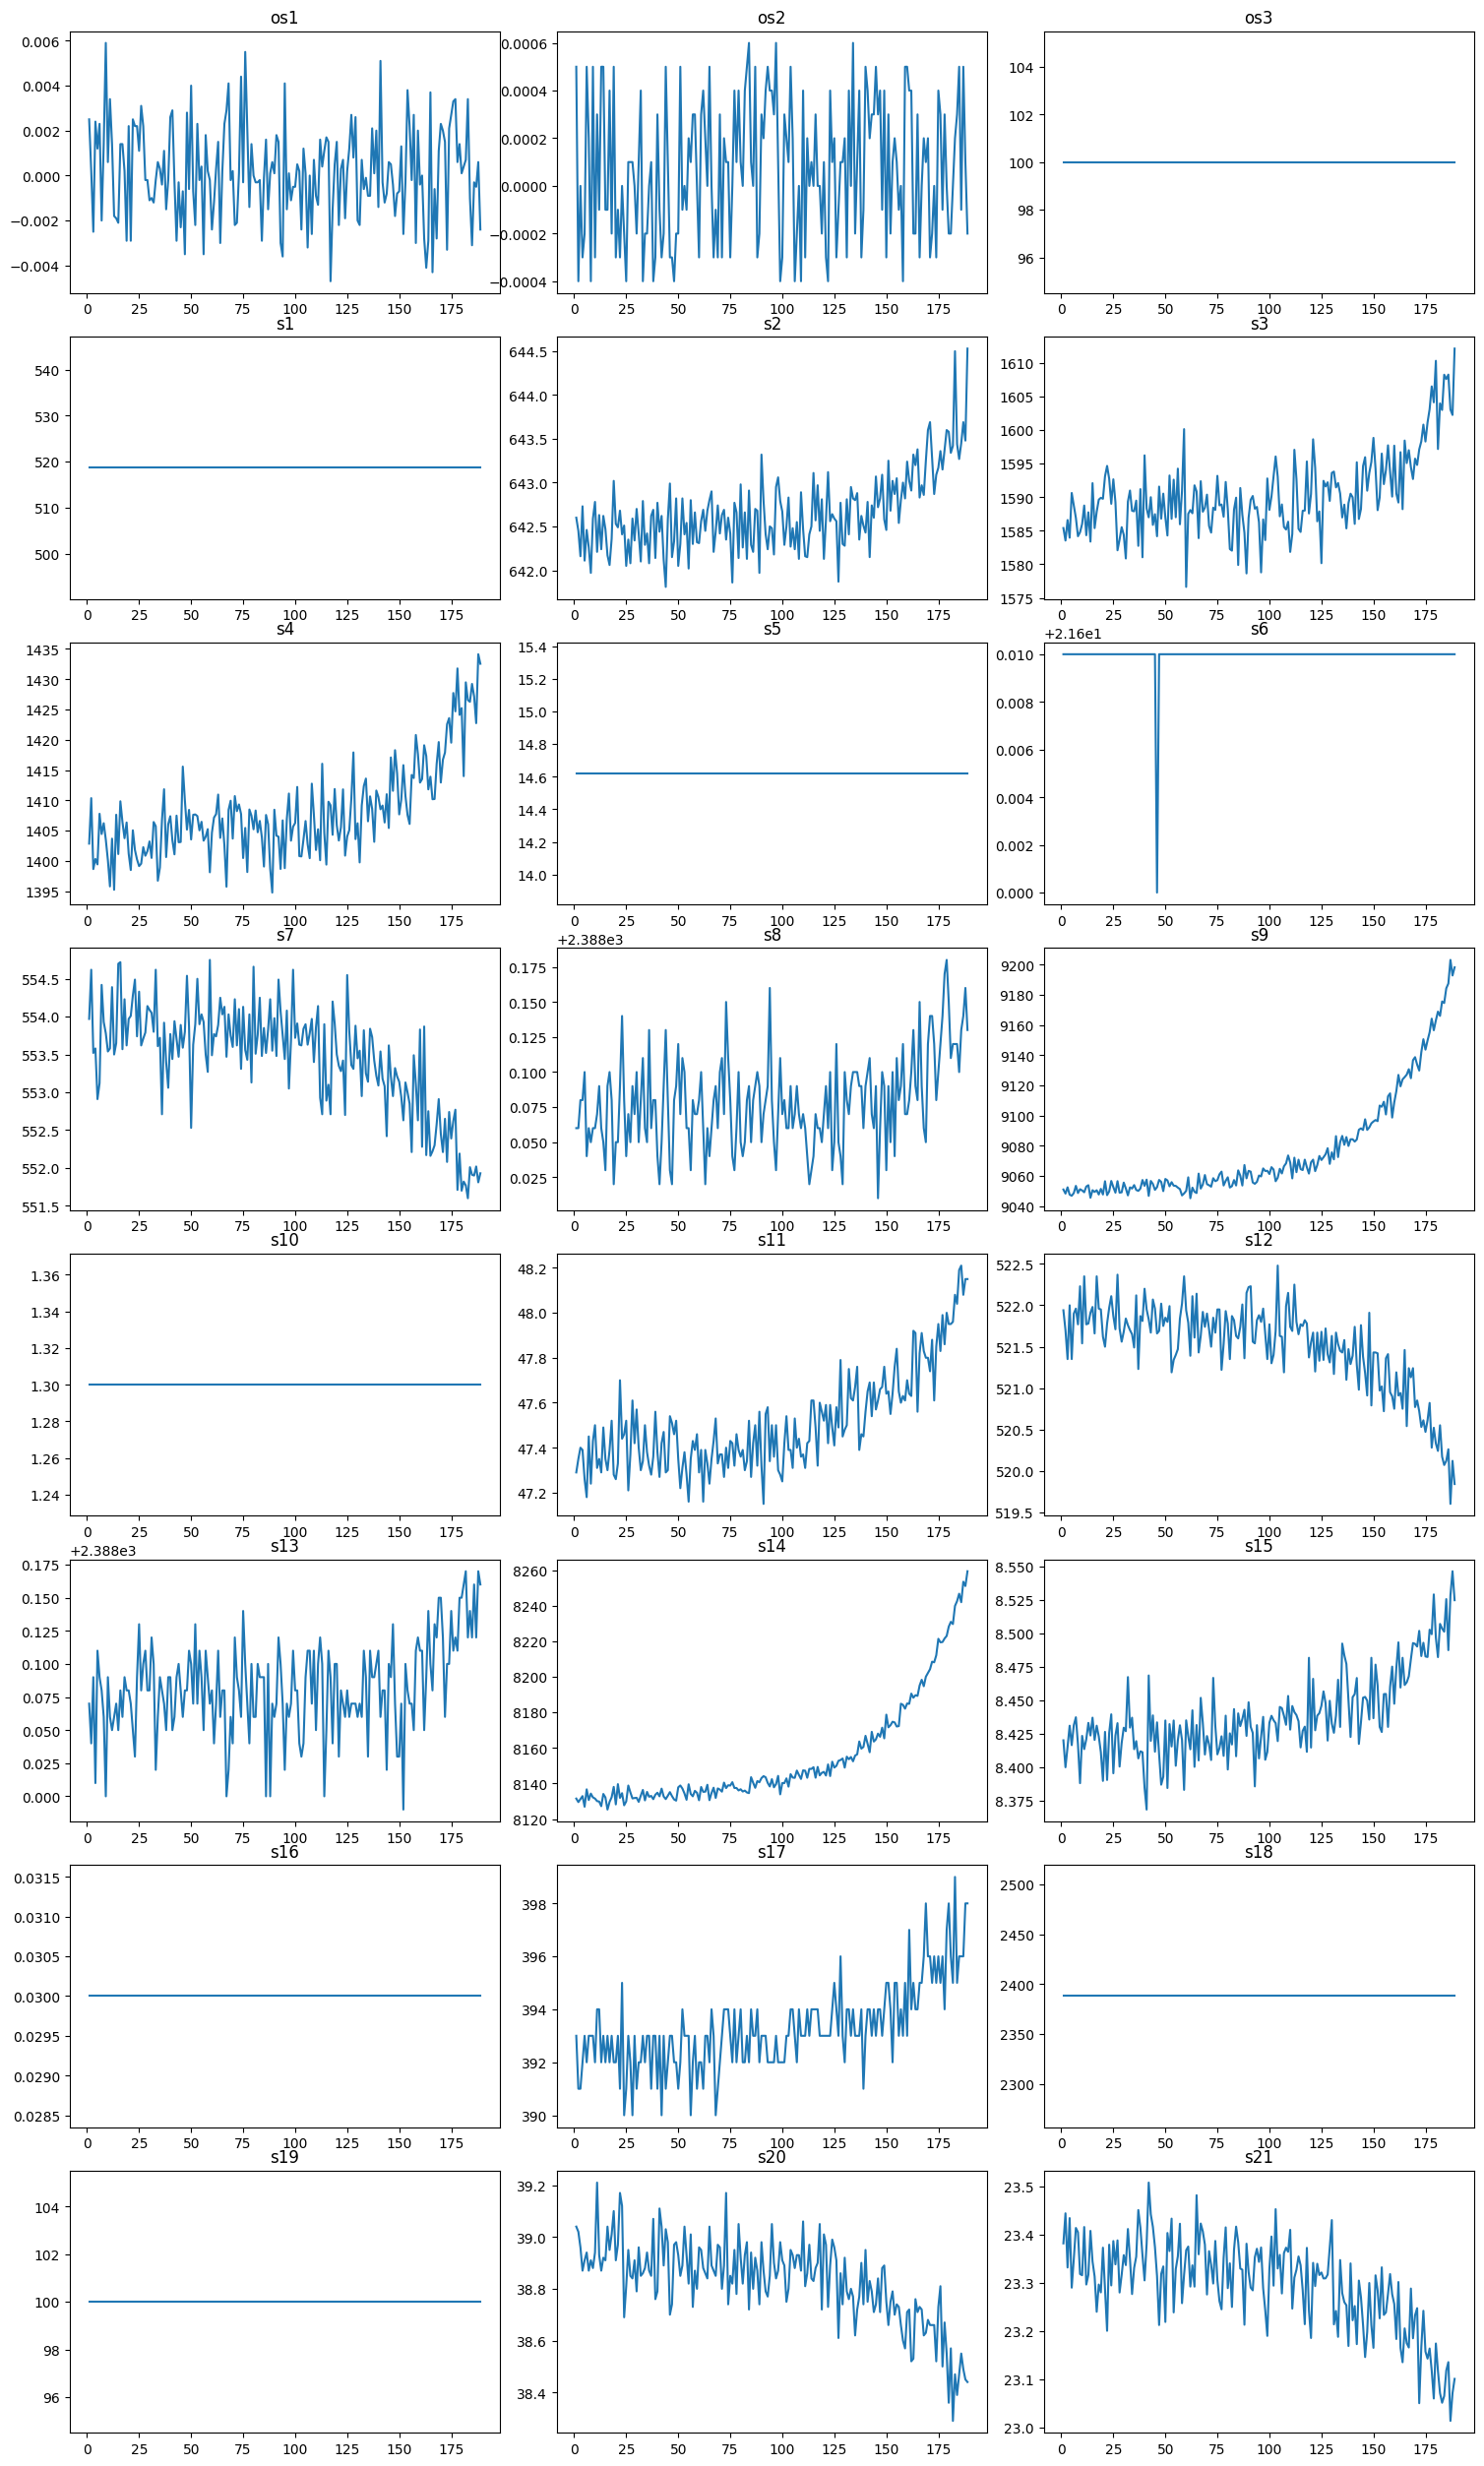

In [ ]:
sample=4
sample_df=df_train[df_train['unit']==sample].copy()

fig,axes=plt.subplots(8,3, figsize=(15,25))
fig.tight_layout()

j=-1
for c in df_train.columns:
  if 's' in c:
    j+=1
    axes[j//3,j%3].plot(sample_df['time'],sample_df[c])
    axes[j//3, j%3].set_title(c)

In [ ]:
df_train[['os3','s1','s5','s6','s10','s16','s18','s19']].describe()

,os3,s1,s5,s6,s10,s16,s18,s19
count,20631.0,20631.00,2.063100e+04,20631.000000,20631.0,2.063100e+04,20631.0,20631.0
mean,100.0,518.67,1.462000e+01,21.609803,1.3,3.000000e-02,2388.0,100.0
std,0.0,0.00,1.776400e-15,0.001389,0.0,1.387812e-17,0.0,0.0
min,100.0,518.67,1.462000e+01,21.600000,1.3,3.000000e-02,2388.0,100.0
25%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
50%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
75%,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0
max,100.0,518.67,1.462000e+01,21.610000,1.3,3.000000e-02,2388.0,100.0


The standaard deviation of this sensors is almost 0. They never change, not representative for the data

In [ ]:
drop_col=['os3','s1','s5','s6','s10','s16','s18','s19']

In [ ]:
df_train=df_train.drop(drop_col,axis=1)
df_test=df_test.drop(drop_col,axis=1)

for df in [df_train,df_test]:
  display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,191
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,190
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,189
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,188
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,187


In [ ]:
#Minmax Scaling
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()

for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])

for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,191
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,190
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,189
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,188
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,187


In [ ]:
#Smoothing Function: Exponentially Weighted Averages

def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)

    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1])
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]

    return sm

s = [1,2,3,4,5]
print(s)
print(f'After Smoothing: {smooth(s)}')

[1, 2, 3, 4, 5]
After Smoothing: [1.         1.50505051 2.01346756 2.52525046 3.04039827]


In [ ]:
#Smoothing each time series for each engine in both training and test sets

for c in df_train.columns:

    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_train[df_train['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm

        df_train[c+'_smoothed'] = sm_list

for c in df_test.columns:

    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_test[df_test['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm

        df_test[c+'_smoothed'] = sm_list

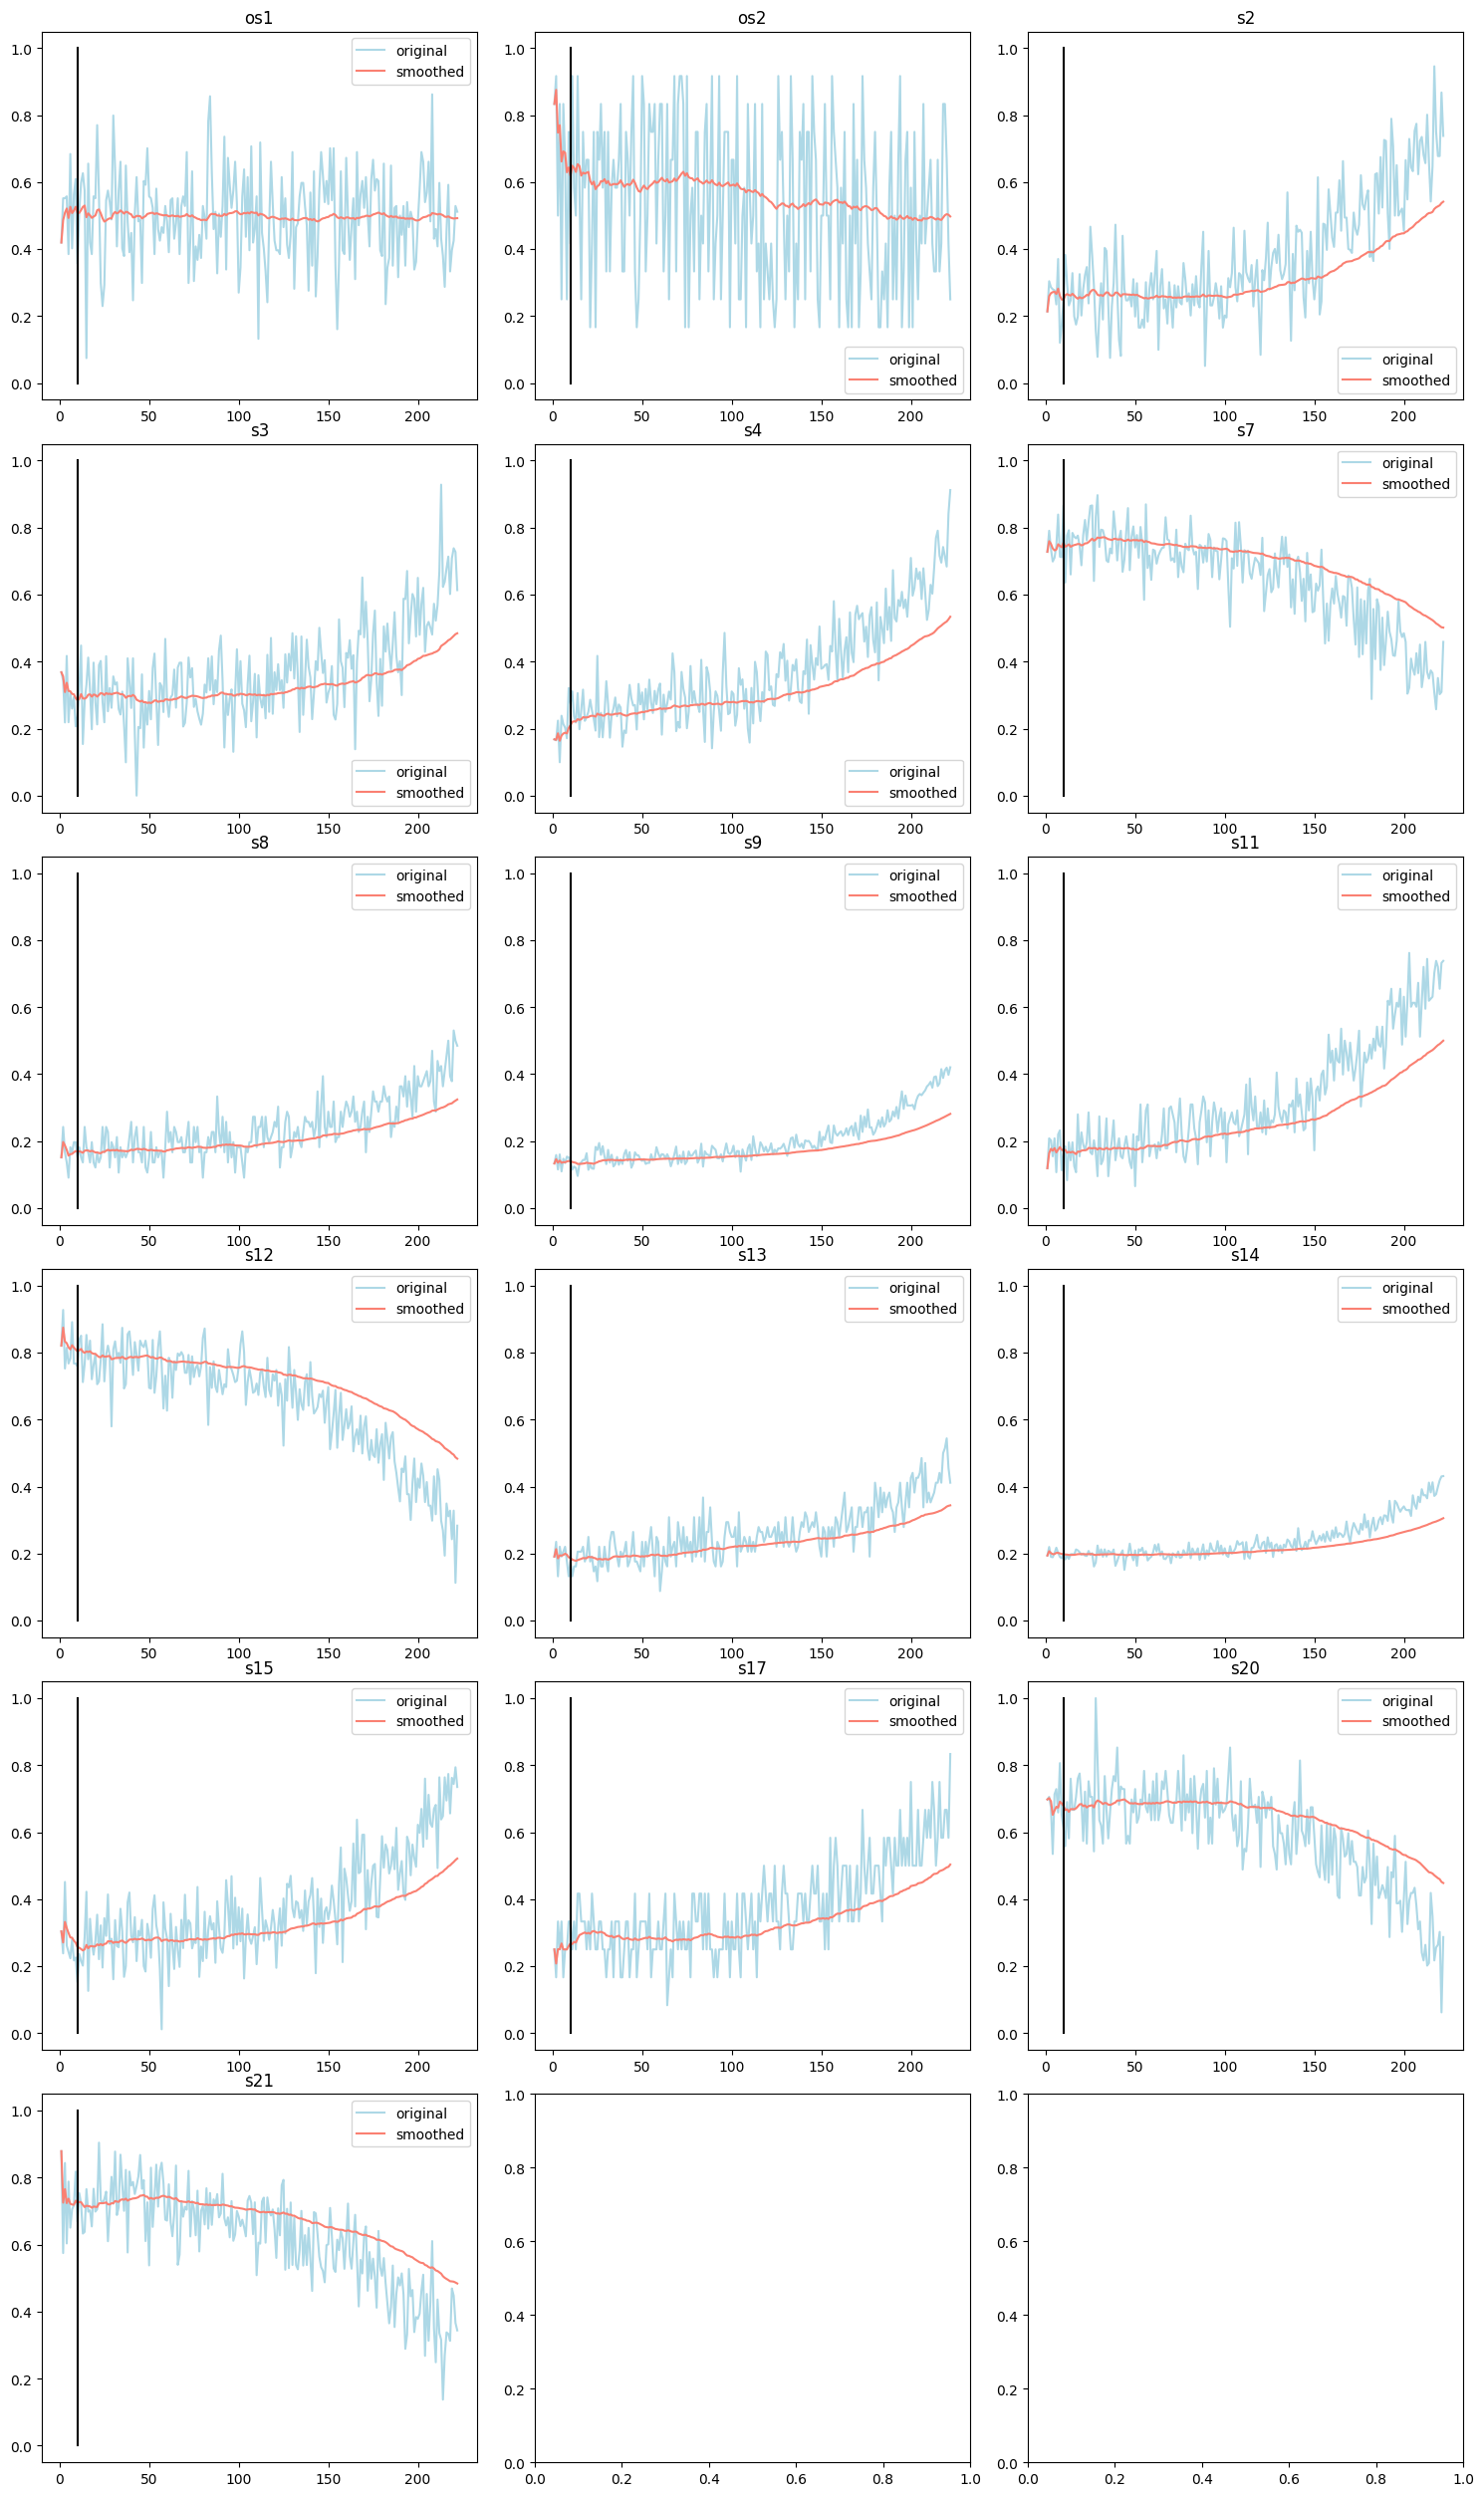

In [ ]:
sample = 10
sample_df = df_train[df_train['unit'] == sample].copy()

fig, axes = plt.subplots(6,3, figsize = (15,25))
fig.tight_layout()

j = -1
for c in df_train.columns:

    if ('s' in c) and ('smoothed' not in c):
        j += 1
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
        axes[j // 3, j % 3].plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
        axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
        axes[j // 3, j % 3].set_title(c)
        axes[j // 3, j % 3].legend()

In [ ]:
#Remove the original series

for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)

for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.535237,0.208754,0.233936,0.430144,0.331412,0.676638,0.227120,0.104951,0.375060,0.700028,0.243018,0.181025,0.387888,0.333333,0.689688,0.727870,190
2,1,3,0.439208,0.392826,0.271154,0.409527,0.344714,0.688033,0.242630,0.116885,0.332528,0.732432,0.235390,0.177885,0.377535,0.276652,0.668677,0.691652,189
3,1,4,0.465234,0.420437,0.289760,0.370016,0.341231,0.701612,0.262094,0.118852,0.289798,0.772801,0.250520,0.177113,0.323193,0.291254,0.644194,0.684112,188
4,1,5,0.449741,0.402305,0.302174,0.346587,0.354428,0.694673,0.258000,0.125327,0.282753,0.767278,0.247350,0.176618,0.339614,0.317360,0.632735,0.688357,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,191
1,1,2,0.487054,0.497475,0.345899,0.345454,0.245626,0.729436,0.189164,0.137245,0.298521,0.693438,0.242870,0.168831,0.260578,0.375421,0.620781,0.674457,190
2,1,3,0.497321,0.526674,0.356308,0.345854,0.271685,0.714661,0.202125,0.144331,0.328579,0.695452,0.235292,0.164345,0.327936,0.389448,0.657477,0.690404,189
3,1,4,0.560197,0.519802,0.359960,0.330216,0.306804,0.705615,0.200797,0.134383,0.309869,0.664050,0.239081,0.165825,0.309667,0.353523,0.659845,0.683115,188
4,1,5,0.564415,0.515680,0.366539,0.334768,0.312057,0.703206,0.193692,0.127725,0.302363,0.679389,0.235232,0.163103,0.307839,0.314626,0.659651,0.690038,187


In [ ]:
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [ ]:
n_features = len([c for c in df_train.columns if 's' in c])
window = 20
print(f'number of features: {n_features}, window size: {window}')

number of features: 16, window size: 20


In [ ]:
np.random.seed(5)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

[8, 9, 16, 17, 28, 31, 45, 54, 62, 63, 66, 74, 76, 77, 78, 79, 81, 91, 93, 100]


In [ ]:
train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

In [ ]:
class data(Dataset):

    def __init__(self, list_indices, df_train):

        self.indices = list_indices
        self.df_train = df_train

    def __len__(self):

        return len(self.indices)

    def __getitem__(self, idx):

        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind : ind + 20, :].drop(['time','unit','rul'], axis = 1).copy().to_numpy()
        y_ = self.df_train.iloc[ind + 19]['rul']

        return X_, y_

torch.manual_seed(5)

train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)

units = np.arange(1,101)

class test(Dataset):

    def __init__(self, units, df_test):

        self.units = units
        self.df_test = df_test

    def __len__(self):

        return len(self.units)

    def __getitem__(self, idx):

        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-20:,:].drop(['index','unit','time','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()

        return X_, y_

test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100)

In [ ]:
device = 'cpu'

class LSTMRegressor(nn.Module):

    def __init__(self, n_features, hidden_units):
        super().__init__()
        self.n_features = n_features
        self.hidden_units = hidden_units
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size = n_features, hidden_size = self.hidden_units, batch_first = True, num_layers = self.n_layers)
        self.linear1 = nn.Linear(in_features=self.hidden_units, out_features=12)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=12, out_features=12)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=12, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[0])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out).flatten()

        return out

learning_rate = 0.001
n_hidden_units = 12

torch.manual_seed(15)

model = LSTMRegressor(n_features, n_hidden_units).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ks = [key for key in model.state_dict().keys() if 'linear' in key and '.weight' in key]

for k in ks:
    nn.init.kaiming_uniform_(model.state_dict()[k])

bs = [key for key in model.state_dict().keys() if 'linear' in key and '.bias' in key]

for b in bs:
    nn.init.constant_(model.state_dict()[b], 0)

In [ ]:
def validation():
    model.eval()
    X, y = next(iter(valloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

    with torch.no_grad():
        y_pred = model(X)
        val_loss = loss_fn(y_pred, y).item()

    return val_loss

loss_L1 = nn.L1Loss()

def test():
    model.eval()
    X, y = next(iter(testloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

    with torch.no_grad():
        y_pred = model(X)
        test_loss_MSE = loss_fn(y_pred, y).item()
        test_loss_L1 = loss_L1(y_pred, y).item()

    return test_loss_MSE, test_loss_L1,  y_pred, y

In [ ]:
#Overfitting a minibatch

#X, y = next(iter(trainloader))

#X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

#model.train()

#for i in tqdm(range(0,30000)):

#    y_pred = model(X)
#    loss = loss_fn(y_pred, y)

#    if (i+1) % 2000 == 0:
#        sleep(0.5)
#        print(loss.item())
#    optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

In [ ]:
T = []
V = []

epochs = 100

model.train()

for i in tqdm(range(epochs)):

    L = 0

    for batch, (X,y) in enumerate(trainloader):

        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_loss = validation()

    T.append(L/len(trainloader))
    V.append(val_loss)

    if (i+1) % 10 == 0:
        sleep(0.5)
        print(f'epoch:{i+1}, avg_train_loss:{L/len(trainloader)}, val_loss:{val_loss}')

        model.train()

 10%|█         | 10/100 [02:38<23:30, 15.68s/it]

epoch:10, avg_train_loss:1661.4512388516316, val_loss:1008.1441650390625


 20%|██        | 20/100 [05:14<20:54, 15.68s/it]

epoch:20, avg_train_loss:914.5171333245471, val_loss:876.6409912109375


 30%|███       | 30/100 [07:50<18:13, 15.62s/it]

epoch:30, avg_train_loss:789.3205004666759, val_loss:662.6696166992188


 40%|████      | 40/100 [10:26<15:57, 15.96s/it]

epoch:40, avg_train_loss:765.1491434553028, val_loss:737.5032348632812


 50%|█████     | 50/100 [13:02<13:12, 15.86s/it]

epoch:50, avg_train_loss:722.2188235932747, val_loss:848.4628295898438


 60%|██████    | 60/100 [15:39<10:31, 15.79s/it]

epoch:60, avg_train_loss:701.9995077521401, val_loss:1012.4417724609375


 70%|███████   | 70/100 [18:15<07:56, 15.87s/it]

epoch:70, avg_train_loss:703.5225997519705, val_loss:761.5509643554688


 80%|████████  | 80/100 [20:51<05:17, 15.85s/it]

epoch:80, avg_train_loss:659.9429001259592, val_loss:731.0853271484375


 90%|█████████ | 90/100 [23:27<02:36, 15.66s/it]

epoch:90, avg_train_loss:596.2633773668678, val_loss:595.6099853515625


100%|██████████| 100/100 [26:04<00:00, 15.64s/it]

epoch:100, avg_train_loss:572.1904061916655, val_loss:624.1705932617188


In [ ]:
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.clear()
    line1, = ax.plot(np.arange(1,i+1), T[:i], label = 'train_loss')
    line2, = ax.plot(np.arange(1,i+1), V[:i], label = 'val_loss')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,101)
    ax.set_ylim(0,4000)
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE')

    return line1, line2

animation = FA(fig, animate, np.arange(1,len(T)+1), interval = 50)

%time animation.save('animation3.gif', writer='imagemagick', fps=20)

plt.close(fig)

CPU times: user 18.8 s, sys: 699 ms, total: 19.5 s
Wall time: 19.4 s


3.Prediction on test

In [ ]:
mse, l1, y_pred, y = test()

print(f'Test MSE:{round(mse,2)}, L1:{round(l1,2)}')

Test MSE:3073.42, L1:43.53


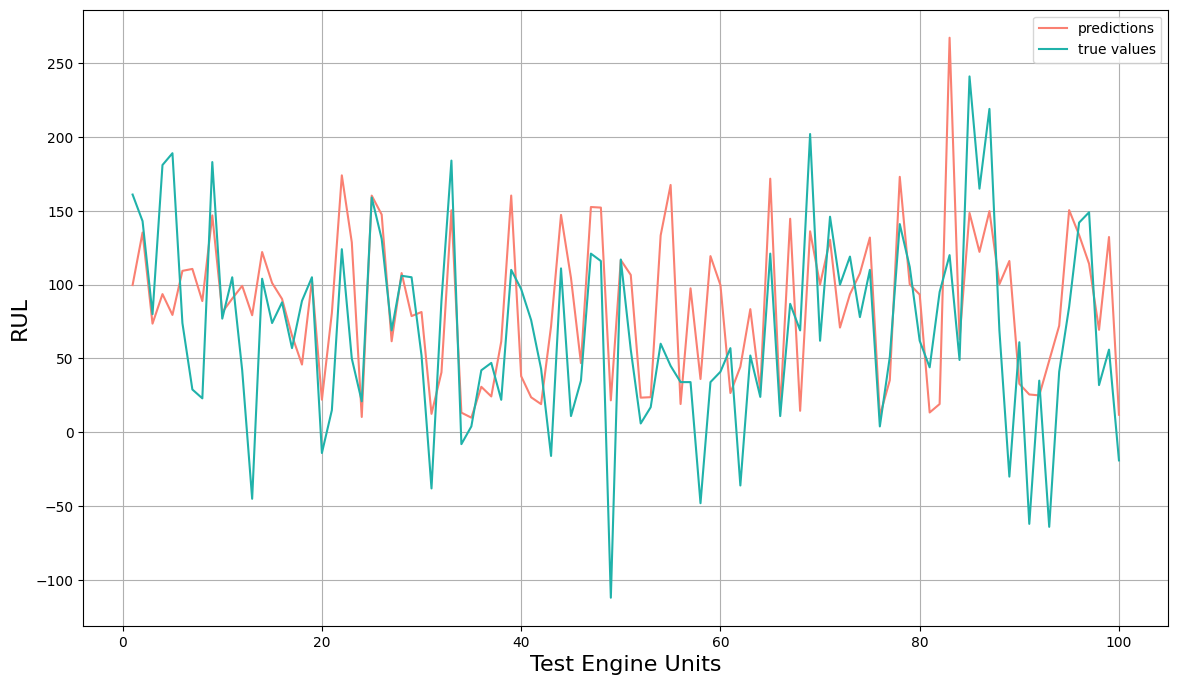

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(np.arange(1,101), y_pred.numpy(), label = 'predictions', c = 'salmon')
ax.plot(np.arange(1,101), y.numpy(), label = 'true values', c = 'lightseagreen')
ax.set_xlabel('Test Engine Units', fontsize = 16)
ax.set_ylabel('RUL', fontsize = 16)
ax.grid(True)
ax.legend()
plt.show()